# Initialization

In [1]:
PATH = "archive/realKnownCause/realKnownCause/ambient_temperature_system_failure.csv"
FIG_SIZE = (10, 6)
TIME_ID_OF_DAY_INTERVAL = 2
SUNRISE_HOUR = 7
SUNSET_HOUR = 21
FEATURES = ['hour', 'timeId', 'dayOfWeek', 'isWeekend']
RANDOM_STATE = 42

In [2]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from scipy.optimize import curve_fit
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

## Preparing Data

In [3]:
def read_csv(path=PATH):
    return pd.read_csv(path)

In [4]:
timeserie = read_csv(PATH)
timeserie['timestamp'] = pd.to_datetime(timeserie['timestamp'])
timeserie['target'] = (timeserie['value'] - 32) * 5 / 9
timeserie = timeserie.drop(['value'], axis=1)

<AxesSubplot:xlabel='timestamp', ylabel='target'>

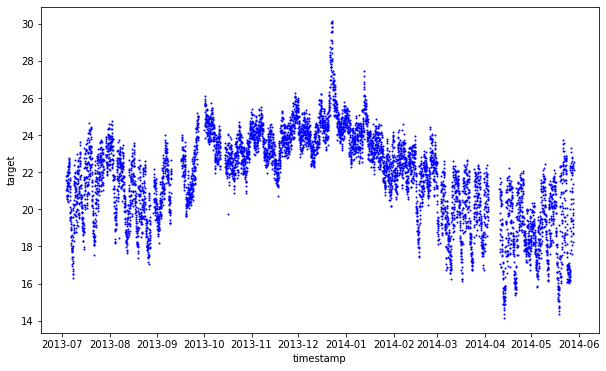

In [5]:
timeserie.plot.scatter(x='timestamp', y='target', s=1, figsize=FIG_SIZE, c='blue')

timeserie.info()

In [6]:
timeserie.describe()

,target
count,7267.000000
mean,21.801352
std,2.359727
min,14.143559
25%,20.205228
50%,22.143607
75%,23.572754
max,30.124007


In [7]:
def plot_anomalies(timeserie_df, is_normal):
    colors = ['red' if o==0 else 'blue' for o in is_normal]
    sizes = [30 if o==0 else 1 for o in is_normal]
    timeserie_df.plot.scatter(x='timestamp', y='target', c=colors, s=sizes, figsize=FIG_SIZE)

## Feature Engineering

Extracting features from timestamp would be relevant to temperature such as hour of day, day of week, or even day of month or a day is holiday or not, would have an effect on the temperature. 

In [8]:
timeserie['hour'] = (timeserie.timestamp.dt.hour).astype(int)
timeserie['timeId'] = ((timeserie.hour // TIME_ID_OF_DAY_INTERVAL) * TIME_ID_OF_DAY_INTERVAL).astype(int)
timeserie['dayOfWeek'] = (timeserie.timestamp.dt.dayofweek).astype(int)
timeserie['isWeekend'] = (timeserie.dayOfWeek < 5).astype(int)


In [9]:
timeserie = timeserie[timeserie.columns.intersection(FEATURES + ['target', 'timestamp'])]

In [10]:
X, y = timeserie.drop(columns=['target', 'timestamp']), timeserie['target']

In [11]:
X

,hour,timeId,dayOfWeek,isWeekend
0,0,0,3,1
1,1,0,3,1
2,2,2,3,1
3,3,2,3,1
4,4,4,3,1
...,...,...,...,...
7262,11,10,2,1
7263,12,12,2,1
7264,13,12,2,1
7265,14,14,2,1


In [12]:
standard_scaler = preprocessing.StandardScaler()
scaled_features = standard_scaler.fit_transform(X)
X = pd.DataFrame(scaled_features, columns=FEATURES)

## Exploratory Data Analysis

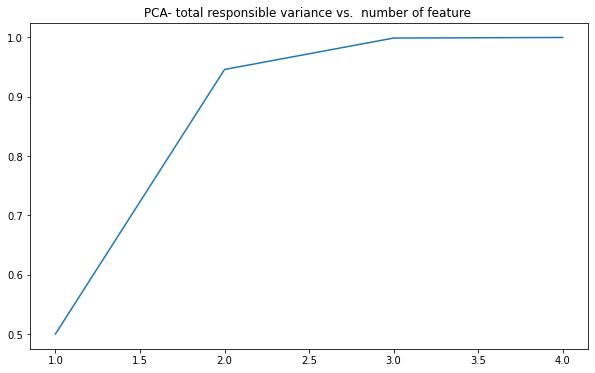

In [13]:
number_of_feature = []
responsible_variance = []
for i in range(1, X.shape[1] + 1):
    pca = PCA(n_components=i)
    X_train = pca.fit_transform(X)
    explained_variance = pca.explained_variance_ratio_
    responsible_variance.append(round(sum(explained_variance), 3))
    number_of_feature.append(i)
    
fig, ax = plt.subplots(figsize=FIG_SIZE)
plt.plot(number_of_feature, responsible_variance)
plt.title('PCA- total responsible variance vs.  number of feature ')
plt.show()

So change the dimension to 3 would have no myriad effects to information loss.

## PCA

In [14]:
pca = PCA(n_components=3, random_state=RANDOM_STATE)
X_reduced = pd.DataFrame(pca.fit_transform(X))
X_reconstructed = pd.DataFrame(pca.inverse_transform(X_reduced), columns=FEATURES)

In [15]:
X_reconstructed

,hour,timeId,dayOfWeek,isWeekend
0,-1.627524,-1.627517,0.005769,0.62132
1,-1.555341,-1.555334,0.005769,0.62132
2,-1.338416,-1.338409,0.005769,0.62132
3,-1.266234,-1.266227,0.005769,0.62132
4,-1.049309,-1.049302,0.005769,0.62132
...,...,...,...,...
7262,-0.109802,-0.109799,-0.499331,0.62132
7263,0.107123,0.107126,-0.499330,0.62132
7264,0.179306,0.179309,-0.499331,0.62132
7265,0.396231,0.396234,-0.499330,0.62132


In [16]:
pca.explained_variance_ratio_

array([0.4995884 , 0.44602735, 0.05373211])

In [17]:
reconstructed_errors = np.linalg.norm((X-X_reconstructed), axis=1)
pca_is_normal = (reconstructed_errors < 0.05399).astype(int)

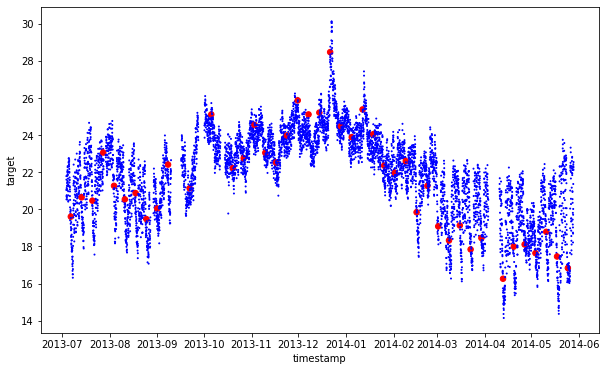

In [18]:
plot_anomalies(timeserie, pca_is_normal)

Anomalies detected by PCA are not detected well.

### KMeans

In [19]:
n_clusters = np.arange(1, 30, 1)
kmeans_clfs = []
scores = []
for n_cluster in n_clusters:
    kmeans_clfs.append(KMeans(n_clusters=n_cluster, init= 'k-means++', n_init=20, random_state=RANDOM_STATE).fit(X_reduced))
for kmeans_clf in kmeans_clfs:
    scores.append(kmeans_clf.score(X_reduced))
    

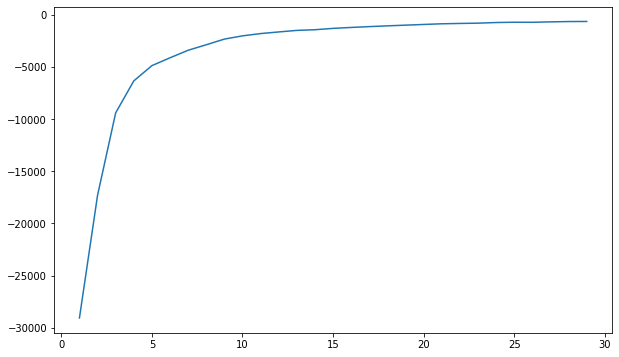

In [20]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
ax.plot(n_clusters, scores)
plt.show()

we set number of clusters to 18

In [21]:
n_cluster = 18
kmeans_distances = np.min(euclidean_distances(kmeans_clfs[n_cluster-1].cluster_centers_, X_reduced), axis=0)
kmeans_is_normal = (kmeans_distances < 0.66).astype(int)

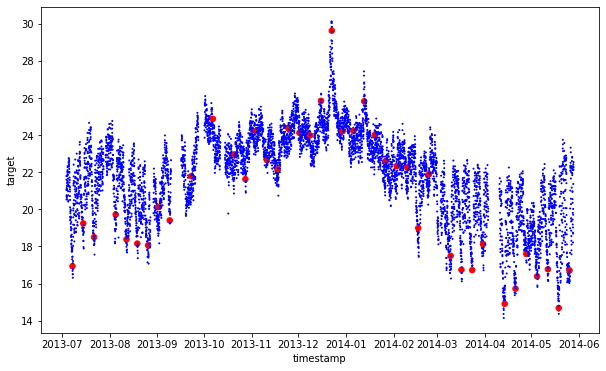

In [22]:
plot_anomalies(timeserie, kmeans_is_normal)

The result makes more sense! 

### Guassion Mixture Model

In [23]:
n_clusters = np.arange(1, 30, 1)
gmm_clfs = []
gmm_scores = []
for n_cluster in n_clusters:
    gmm_clfs.append(GaussianMixture(
        n_components=n_cluster,
        init_params= 'k-means++',
        n_init=3,
        random_state=RANDOM_STATE
    ).fit(X_reduced))
for gmm_clf in gmm_clfs:
    gmm_scores.append(gmm_clf.score(X_reduced))
    

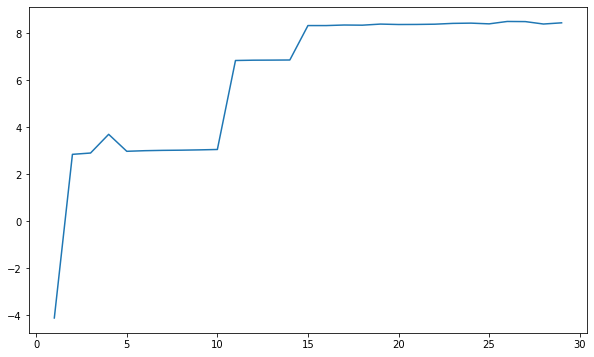

In [24]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
ax.plot(n_clusters, gmm_scores)
plt.show()

16 components would be enough

In [25]:
n_cluster = 25
gmm_probs = np.max(gmm_clfs[n_cluster - 1].predict_proba(X_reduced), axis=1)
gmm_is_normal = (gmm_probs > 0.53).astype(int)

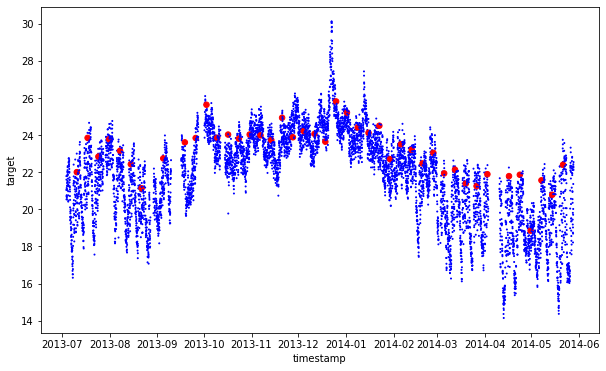

In [26]:
plot_anomalies(timeserie, gmm_is_normal)

In [27]:
envelope =  EllipticEnvelope(contamination = 0.01) 
envelope.fit(X_reduced)
env_is_normal = envelope.predict(X_reduced)
env_is_normal = [1 if e == 1 else 0 for e in env_is_normal]

/home/alireza/.local/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-30.158587741220568 > -30.159044642754189). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
/home/alireza/.local/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-30.154883220041398 > -30.155380204889358). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
/home/alireza/.local/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-30.155963874586462 > -30.156448021548979). You may want to try with a higher value of support_fraction (current value: 0.501).
  warn

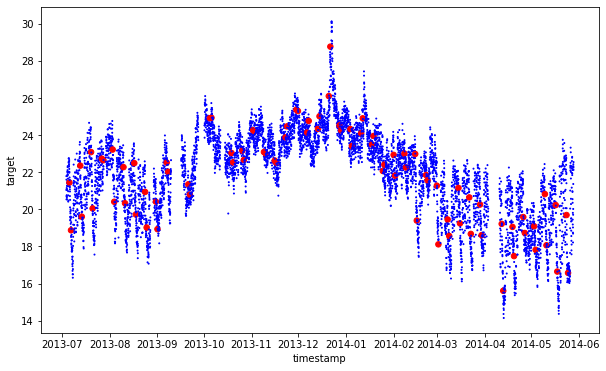

In [28]:
plot_anomalies(timeserie, env_is_normal)

### Isolation Forest

In [29]:
isolated_forset_clf=IsolationForest(n_estimators=100,max_samples='auto',contamination=float(0.01),random_state=RANDOM_STATE)
isolated_forset_clf.fit(X_reduced)

IsolationForest(contamination=0.01, random_state=42)

In [30]:
iso_is_normal = isolated_forset_clf.predict(X_reduced)
iso_is_normal = [0 if i == -1 else 1 for i in iso_is_normal]

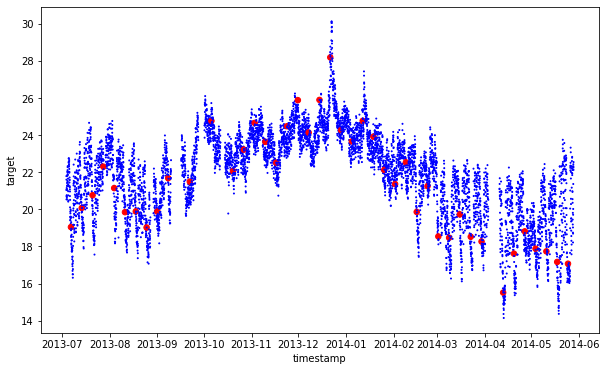

In [31]:
plot_anomalies(timeserie, iso_is_normal)